In [1]:
# data manipulation libraries
import pandas as pd
import numpy as np
import copy
import os

# imports visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# take this off if using GPU
# Ensure no GPUs are visible to TensorFlow
# tf.config.set_visible_devices([], 'GPU')  # Disable GPU
# tf.config.experimental.set_visible_devices([], 'GPU')

# tensorflow and keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications.convnext import preprocess_input # as covnext_preprocess_input
import datetime
import os

# trying to suppress warnings
tf.get_logger().setLevel('ERROR')

# Suppress annoying warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # supress tensorflow warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# evaluation
from sklearn.metrics import confusion_matrix,  f1_score, accuracy_score

2025-02-05 14:17:59.813662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738765080.458472    3537 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738765080.651157    3537 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 14:18:02.561210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Functions for evaluation

A lot of this was from NN coursework

In [2]:
# The code for the charts is based on code from pp74-75 from Deep Learning with Python [8].
# function to create charts for training and validation loss/accuracy
# based on code from p75 DLWP
def loss_accuracy_charts(hist):
    # gets loss/accuracy data from history object
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    accuracy = hist.history['accuracy']
    val_accuracy = hist.history['val_accuracy']

    epochs = range(1, len(loss) + 1) # this gets numbers of epochs to use in plotting (on the x axis)

    plt.figure(figsize=(12, 5))

    # plot training/validation loss
    plt.subplot(1, 2, 1)  # plots in col 1
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot training/validation accuracy
    plt.subplot(1, 2, 2)  # plots in col 2
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [3]:
#### function to get y_true and y_pred

def get_y_vals(current_model, test_dataset):
    y_true = []
    y_pred = []
    
    for images, labels in test_dataset:
        # append true labels
        y_true.extend(labels.numpy())
        
        # get predictions
        predictions = current_model.predict(images) # https://keras.io/api/models/model_training_apis/
        
        # convert preds back to class labels
        y_pred.extend(np.argmax(predictions, axis=1))
    
    # convert y_true to a flat list
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    return y_true, y_pred

In [4]:
#### function for evaluation of results, gets loss, accuracy from results and calculates F1
def model_results(res, y_true, y_pred):
    print(f"Loss:{res[0]}")
    print(f"Accuracy:{res[1]}")
    print(f"F1 (macro): {f1_score(y_true, y_pred, average='macro')}")
    print(f"F1 (weighted): {f1_score(y_true, y_pred, average='weighted')}")

In [5]:
# function for confusion matrix

def conf_mat_func(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) # create confusion matrix data
    # plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
# brings all functions together to evaluate

def evaluation(current_model,test_dataset,res, history):
    y_true, y_pred = get_y_vals(current_model,test_dataset)
    
    model_results(res,y_true,y_pred)
    
    loss_accuracy_charts(history)
    
    conf_mat_func(y_true,y_pred)

# Model Training

# Convnext v2

Added L2

In [9]:
# function to load and preprocess
def import_data(image_size, batch_size, base_dir, colour):
    # load with 80-20 split
    full_val_test_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='validation',
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
        color_mode = colour
    )
    
    # further split (10%) and test (10%)
    val_size = int(0.5 * tf.data.experimental.cardinality(full_val_test_ds).numpy())
    val_ds = full_val_test_ds.take(val_size)
    test_ds = full_val_test_ds.skip(val_size)
    
    # training set (80%)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='training',
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
        color_mode = colour
    )


    class_names = train_ds.class_names


    # data augmentation pipeline
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2, fill_mode='nearest'),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.1, 0.1, fill_mode='nearest'),
        layers.GaussianNoise(0.1)
    ])

    # https://www.tensorflow.org/guide/data_performance
    AUTOTUNE = tf.data.AUTOTUNE

    # training set pipeline
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))  # normalize for ConvNext
    # sets shuffle size dynamically to be same size as the dataset
    train_ds = train_ds.cache().shuffle(buffer_size=tf.data.experimental.cardinality(train_ds).numpy()).prefetch(buffer_size=AUTOTUNE)
    

    # test and val set pipleine
    val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
    test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds


# directory and image configurations
base_dir = r'/home/azureuser/cloudfiles/code/Users/richesmith/Eurosat_RGB'
image_size = (224, 224)
batch_size = 64
colour = 'rgb'
train_ds, val_ds, test_ds = import_data(image_size, batch_size, base_dir, colour)

#convnext model
convnext_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
convnext_model.trainable = False


# model architecture
model = models.Sequential([
    convnext_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),  # added L2 regularisation
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-5))  # L2 here too
])

# learning rate
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('convnext_model_v2_best_L21e5_LR1e5_8020split.keras', save_best_only=True)

# trains model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # increased epochs to 50
    callbacks=[early_stopping, model_checkpoint]
)

Found 27000 files belonging to 10 classes.
Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 373s 271ms/step - accuracy: 0.2107 - loss: 2.3316 - val_accuracy: 0.4784 - val_loss: 1.5694
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 87s 258ms/step - accuracy: 0.5777 - loss: 1.2936 - val_accuracy: 0.7217 - val_loss: 0.9328
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 90s 265ms/step - accuracy: 0.7267 - loss: 0.9069 - val_accuracy: 0.7928 - val_loss: 0.6894
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 90s 266ms/step - accuracy: 0.7964 - loss: 0.7079 - val_accuracy: 0.8259 - val_loss: 0.5605
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 90s 266ms/step - accuracy: 0.8278 - loss: 0.5887 - val_accuracy: 0.8478 - val_loss: 0.4794
Epoch 6/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 90

I0000 00:00:1738765096.354308    3537 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14780 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5
2025-02-05 14:18:40.395268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 13 of 338
2025-02-05 14:19:00.043696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 38 of 338
2025-02-05 14:19:10.268693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 51 of 338
2025-02-05 14:19:20.469261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 64 of 338
2025-02-05 14:19:40.105635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:19: 

In [10]:
# # evaluates on the test set
results = model.evaluate(test_ds)

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - accuracy: 0.9314 - loss: 0.2058


In [11]:
# get test results
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

Test Loss: 0.1895948201417923, Test Accuracy: 0.9351032376289368


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-02-05 15:38:31.577982: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


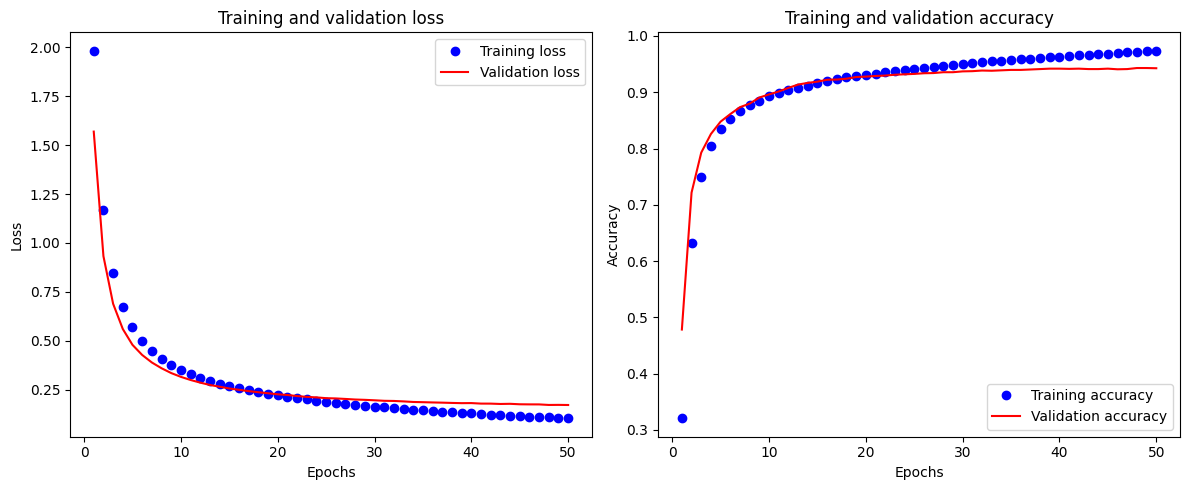

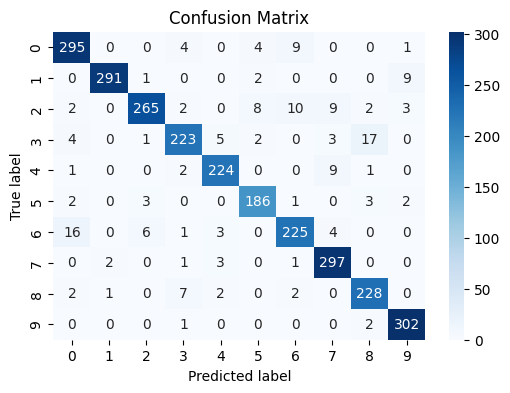

In [12]:
# get evaluation
evaluation(model,test_ds,results,history)

# Convnext v3

Increased L2

Added LR decay

Test Loss: 0.15669110417366028, Test Accuracy: 0.9494837522506714

In [13]:
# function to load and preprocess
def import_data(image_size, batch_size, base_dir, colour):
    # load with 80-20 split
    full_val_test_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='validation',
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
        color_mode = colour
    )
    
    # further split (10%) and test (10%)
    val_size = int(0.5 * tf.data.experimental.cardinality(full_val_test_ds).numpy())
    val_ds = full_val_test_ds.take(val_size)
    test_ds = full_val_test_ds.skip(val_size)
    
    # training set (80%)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='training',
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
        color_mode = colour
    )


    class_names = train_ds.class_names


    # data augmentation pipeline
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2, fill_mode='nearest'),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.1, 0.1, fill_mode='nearest'),
        layers.GaussianNoise(0.1)
    ])

    # https://www.tensorflow.org/guide/data_performance
    AUTOTUNE = tf.data.AUTOTUNE

    # training set pipeline
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))  # normalize for ConvNext
    # sets shuffle size dynamically to be same size as the dataset
    train_ds = train_ds.cache().shuffle(buffer_size=tf.data.experimental.cardinality(train_ds).numpy()).prefetch(buffer_size=AUTOTUNE)
    

    # test and val set pipleine
    val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
    test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds


# directory and image configurations
base_dir = r'/home/azureuser/cloudfiles/code/Users/richesmith/Eurosat_RGB'
image_size = (224, 224)
batch_size = 64
colour = 'rgb'
train_ds, val_ds, test_ds = import_data(image_size, batch_size, base_dir, colour)


# defines the convnext model
convnext_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
convnext_model.trainable = False


# model architecture

# decreased L2 slightly
model = models.Sequential([
    convnext_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-6)),  # added L2 regularisation
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-6))  # L2 here too
])

# Adam default is 0.001
# added learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4, decay_steps=1000, decay_rate=0.96
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('convnext_model_v3_best_L21e6_LRDecay_8020split_pat10.keras', save_best_only=True)

# train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Epoch 1/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 365s 266ms/step - accuracy: 0.6017 - loss: 1.2540 - val_accuracy: 0.8895 - val_loss: 0.4348
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 88s 259ms/step - accuracy: 0.8982 - loss: 0.3313 - val_accuracy: 0.9215 - val_loss: 0.2354
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 90s 266ms/step - accuracy: 0.9278 - loss: 0.2350 - val_accuracy: 0.9282 - val_loss: 0.2038
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 90s 266ms/step - accuracy: 0.9430 - loss: 0.1877 - val_accuracy: 0.9315 - val_loss: 0.1894
Epoch 5/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 90s 266ms/step - accuracy: 0.9535 - loss: 0.1555 - val_accuracy: 0.9397 - val_loss: 0.1672
Epoch 6/5

2025-02-05 15:38:52.393043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:610: Filling up shuffle buffer (this may take a while): 13 of 338
2025-02-05 15:39:02.653630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:610: Filling up shuffle buffer (this may take a while): 26 of 338
2025-02-05 15:39:22.353267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:610: Filling up shuffle buffer (this may take a while): 51 of 338
2025-02-05 15:39:32.590988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:610: Filling up shuffle buffer (this may take a while): 64 of 338
2025-02-05 15:39:52.275776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:610: Filling up shuffle buffer (this may take a while): 89 of 338
2025-02-05 15:40:02.505350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:610: Filling up shuffle buffer (this may take a whil

In [14]:
# # evaluateson the test set
results = model.evaluate(test_ds)

43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.9456 - loss: 0.1719


In [15]:
# get test results
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

Test Loss: 0.15669110417366028, Test Accuracy: 0.9494837522506714


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

2025-02-05 16:19:20.569481: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


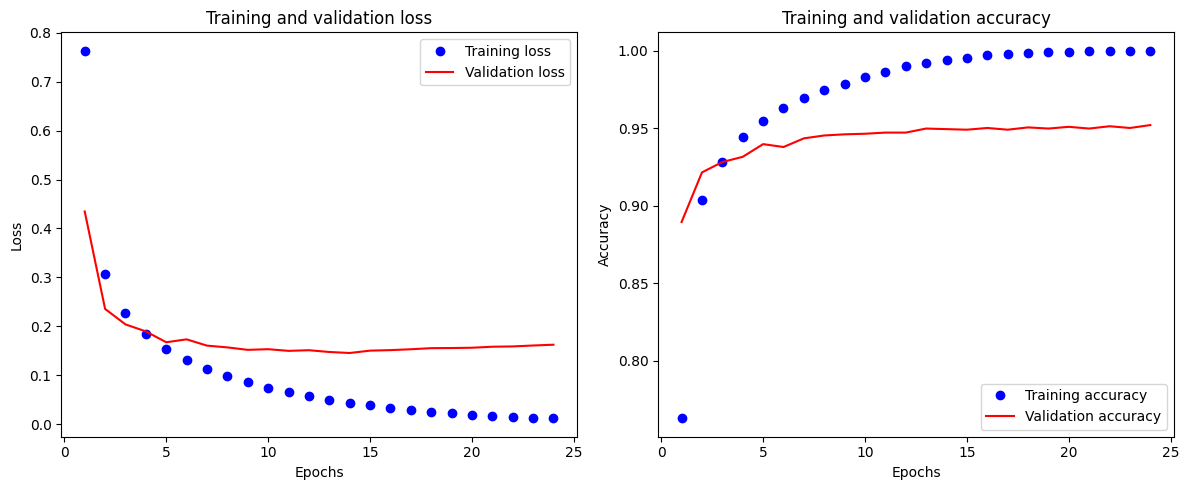

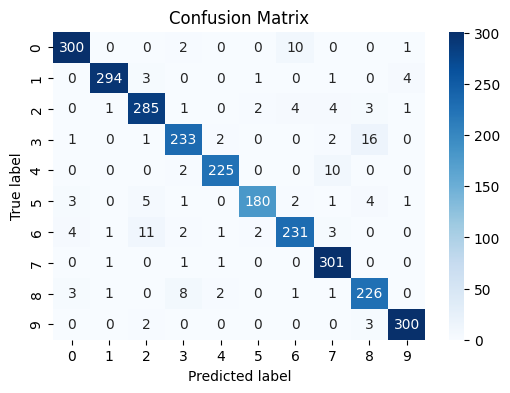

In [16]:
# get evaluation
evaluation(model,test_ds,results,history)